<a href="https://colab.research.google.com/github/ftc8569/2020-ftc-vision/blob/master/FindRings_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ensure that the proper packages are intalled...

In [1]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


Now clone our github repo to get all of our files.  To get the path to a file, find it in the file browser to the left.  Then, right click it and select "Copy File Path" and paste that path into the code block.

In [ ]:
# Clone the entire repo.  Here I set the destination path to "/content/drive/My Drive/2020-ftc-vision" which is my mounted google drive
# if you want to just create a temporary folder (that will be recylced when the runtime restarts), set the path to just "2020-ftc-vision"
!git clone https://github.com/ftc8569/2020-ftc-vision.git  "/2020-ftc-vision"
%cd "/2020-ftc-vision"
!ls

Cloning into '/2020-ftc-vision'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 135 (delta 33), reused 98 (delta 11), pack-reused 0
Receiving objects: 100% (135/135), 20.07 MiB | 27.01 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/2020-ftc-vision
colab  field-images  LICENSE  misc  opencv  README.md


Import the necessary libraries.  Note that opencv's cv2.imshow crashed colab notebooks so we import a patched version as "cv2_imshow" and we use that one.

In [9]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Let's load a series of images so that we can test on all of them

In [3]:
images = { "4rings" : [], "1ring" : [], "noring":[] }
imageDir = '../field-images/carl-field-webcam-oct-2'

for filename in os.listdir(imageDir):
    if (filename.startswith("start-4rings-tall") or filename.startswith("start-1ring-tall") or filename.startswith("start-noring-tall")) and filename.endswith(".jpg"):
      imgType = filename.split('-')[1]
      filePath = f"{imageDir}/{filename}"
      print(f"loading {filePath}")
      images[imgType].append((filename, cv2.imread(filePath))) 

loading ../field-images/carl-field-webcam-oct-2/start-1ring-tall-01.jpg
loading ../field-images/carl-field-webcam-oct-2/start-1ring-tall-02.jpg
loading ../field-images/carl-field-webcam-oct-2/start-1ring-tall-03.jpg
loading ../field-images/carl-field-webcam-oct-2/start-1ring-tall-04.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-01.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-02.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-03.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-04.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-05.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-06.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-07.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-08.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4rings-tall-09.jpg
loading ../field-images/carl-field-webcam-oct-2/start-4

Now let's attempt a calibration routine to determine the bounding box to crop for a given starting position and the hsv lower and upper bounds to use.  The idea here is that we could run a "ring detection calibration" opmode on the robot where it would take multiple pictures of four rings, one ring, no ring at slightly varying but plausible starting positions.  We would then use our current best guess hsv limits on the whole image to determine:
* the generous bounding box that we will crop images into at the start.
* the refined hsv limits for the that image crop
* the contour volume limits for determining 0, 1, or 4 rings
* then we can save these values out for use in actual competition

In [4]:
# first determine the generous bounding box using the 4rings images (this will yield the largest box)
boundingRects = []

# these are our best/starting guess values
lower = np.array([6,155,70])
upper = np.array([67,255,255])

# define the core image processing pipeline function, return
def processRingImage(img, hsvLower = lower, hsvUpper = upper):
  imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(imgHSV, hsvLower, hsvUpper)
  blurMask = cv2.medianBlur(mask,11) 
  
  # find the bounding rectangles, here we assume that the largest contour area that we find are the rings
  contours, hierarchy = cv2.findContours(blurMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  if(len(contours) > 0):
    rect = cv2.boundingRect(contours[0])
  else:
    rect = None
  return(rect)

for image in images['4rings']:
  print(f"Finding bounding box for {image[0]}")
  boundingRect = processRingImage(image[1])
  boundingRects.append(boundingRect)

Finding bounding box for start-4rings-tall-01.jpg
Finding bounding box for start-4rings-tall-02.jpg
Finding bounding box for start-4rings-tall-03.jpg
Finding bounding box for start-4rings-tall-04.jpg
Finding bounding box for start-4rings-tall-05.jpg
Finding bounding box for start-4rings-tall-06.jpg
Finding bounding box for start-4rings-tall-07.jpg
Finding bounding box for start-4rings-tall-08.jpg
Finding bounding box for start-4rings-tall-09.jpg
Finding bounding box for start-4rings-tall-10.jpg
Finding bounding box for start-4rings-tall-11.jpg
Finding bounding box for start-4rings-tall-12.jpg
Finding bounding box for start-4rings-tall-13.jpg
Finding bounding box for start-4rings-tall-14.jpg
Finding bounding box for start-4rings-tall-15.jpg
Finding bounding box for start-4rings-tall-16.jpg
Finding bounding box for start-4rings-tall-17.jpg
Finding bounding box for start-4rings-tall-18.jpg
Finding bounding box for start-4rings-tall-19.jpg


297 1056 214 158
83 1017 642 237


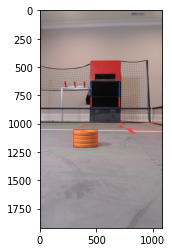

In [10]:
# now lets draw the rects on the first image
imgWithRects = np.copy(images['4rings'][4][1])
for x,y,w,h in boundingRects:
  cv2.rectangle(imgWithRects,(x,y),(x+w,y+h),(0,0,255), 1)

# now let's compute the average bounding rect and give ourselves some margin around it
ax,ay,aw,ah = np.amax(boundingRects,0)
print(ax,ay,aw,ah)
xExpansionFactor = 3
yExpansionFactor = 1.5
mw = int(aw * xExpansionFactor)
mh = int(ah * yExpansionFactor)
mx = ax + aw//2 - mw//2
my = ay + ah//2 - mh//2

cv2.rectangle(imgWithRects,(mx,my),(mx+mw,my+mh),(0,255,0), 1)

showImage(imgWithRects)
print(mx,my,mw,mh)


In [8]:
# now let's process all of the image (now dropped within the margin rectangle)
areas = {'noring':[], '1ring': [], '4rings': [] }
cropImages = {'noring':[], '1ring': [], '4rings': [] }
imageTypes = ['noring', '1ring', '4rings']
for imgType in imageTypes:
  for filename, img in images[imgType]:
    cropImg = img[my:my+mh,mx:mx+mw,:]
    boundingRect = processRingImage(cropImg)
    if not boundingRect is None:
      (x,y,w,h) = boundingRect
      area = w * h
    else:
      area = 0
    cropImages[imgType].append((filename, cropImg, boundingRect, area))
    areas[imgType].append(area)

# now lets print one cropped image of each type
for imgType in imageTypes:
  imgWithRect = np.copy(cropImages[imgType][0][1])
  # but we will print out and overlay all bounding rectangles
  for fn, img, br,area in cropImages[imgType]:
    if not br is None:
      (x,y,w,h) = br
      # print(f"bounding rect (x,y,w,h):{ br }, area: { area }")
      cv2.rectangle(imgWithRect,(x,y),(x+w,y+h),(0,0,255), 1)
    else:
      pass
      # print("no bounding rect found")
  cv2.imshow(imgWithRect)

avgArea4Rings = np.mean(areas['4rings'])
stdevArea4Rings = np.std(areas['4rings'])

avgArea1Ring = np.mean(areas['1ring'])
stdevArea1Ring = np.std(areas['1ring'])

print(f"4 rings: avg = {avgArea4Rings}, std = {stdevArea4Rings}" )
print(f"1 ring: avg = {avgArea1Ring}, std = {stdevArea1Ring}" )

# for now just set the threshold to half way between
areaThreshold1Ring = int((0 + avgArea1Ring)/2)
areaThreshold4Rings = int((avgArea1Ring + avgArea4Rings)/2)
print(f"area < { areaThreshold1Ring} : No Rings")
print(f"{ areaThreshold1Ring} <= area < { areaThreshold4Rings} : 1 Ring")
print(f"{ areaThreshold4Rings} <= area : 4 Rings")

4 rings: avg = 32699.315789473683, std = 593.0064393572077
1 ring: avg = 12978.0, std = 0.0
area < 6489 : No Rings
6489 <= area < 22838 : 1 Ring
22838 <= area : 4 Rings


Now let's define a function that will return the number of rings in the photo using the values derived above.

In [ ]:
def getNumberOfRings(img, cropRect = (83, 1017, 642, 237), noRingUpper = 6500, oneRingUpper = 23000 ):
  (mx, my, mw, mh) = cropRect
  cropImg = img[my:my+mh,mx:mx+mw,:]
  rect = processRingImage(cropImg)
  if rect is None:
    return 0
  else:
    (x,y,w,h) = rect
    area = w*h
    if area <= noRingUpper:
      return 0
    elif area <= oneRingUpper:
      return 1
    else:
      return 4

# now to test, lets run all the images and print the numer of rings
for imgType in imageTypes:
  for filename, img in images[imgType]:
    numRings = getNumberOfRings(img)
    print(f"In file {filename}, found {numRings} rings.")

In file start-noring-tall-01.jpg, found 0 rings.
In file start-noring-tall-03.jpg, found 0 rings.
In file start-noring-tall-02.jpg, found 0 rings.
In file start-1ring-tall-02.jpg, found 1 rings.
In file start-1ring-tall-01.jpg, found 1 rings.
In file start-1ring-tall-04.jpg, found 1 rings.
In file start-1ring-tall-03.jpg, found 1 rings.
In file start-4rings-tall-13.jpg, found 4 rings.
In file start-4rings-tall-19.jpg, found 4 rings.
In file start-4rings-tall-16.jpg, found 4 rings.
In file start-4rings-tall-07.jpg, found 4 rings.
In file start-4rings-tall-08.jpg, found 4 rings.
In file start-4rings-tall-06.jpg, found 4 rings.
In file start-4rings-tall-05.jpg, found 4 rings.
In file start-4rings-tall-03.jpg, found 4 rings.
In file start-4rings-tall-04.jpg, found 4 rings.
In file start-4rings-tall-11.jpg, found 4 rings.
In file start-4rings-tall-01.jpg, found 4 rings.
In file start-4rings-tall-17.jpg, found 4 rings.
In file start-4rings-tall-09.jpg, found 4 rings.
In file start-4rings-tal

# This is very experimental
This is just a start at trying to develop a better/fine-tuned hsv lower and upper bounds.  This is probably not necessary and never will be.

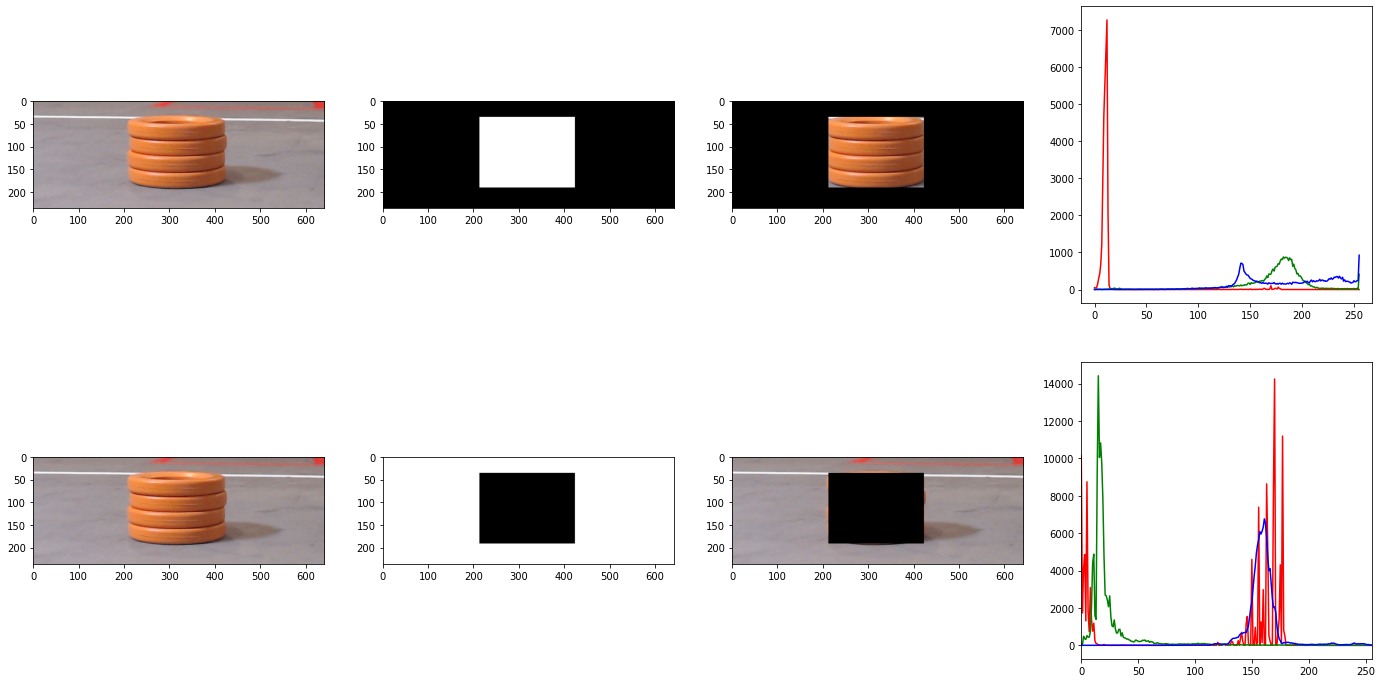

h: mean = 12.61431643625192, std = 19.60652116393391
s: mean = 12.61431643625192, std = 33.5950619353128
v: mean = 186.96445468509984, std = 43.60148740894655


In [ ]:
img = cropImages['4rings'][0][1]
ppimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # conver to RGB for pyplot plt.imshow below

br = cropImages['4rings'][0][2]
(x,y,w,h) = br
hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

# create masks
brmask = np.zeros(img.shape[:2], np.uint8)
brmask[y:y+h, x:x+w] = 255
brmasked_img = cv2.bitwise_and(ppimg,ppimg,mask = brmask)

nonbrmask = np.zeros(img.shape[:2], np.uint8)
nonbrmask[:,:] = 255
nonbrmask[y:y+h, x:x+w] = 0
nonbrmasked_img = cv2.bitwise_and(ppimg,ppimg,mask = nonbrmask)

# Calculate histogram with mask and without mask
# Check third argument for mask
color = ('h','s','v')
hist_nonbr, hist_br = { }, { }
for i,col in enumerate(color):
  hist_nonbr[col] = cv2.calcHist([hsv],[i],nonbrmask,[256],[0,256])
  hist_br[col] = cv2.calcHist([hsv],[i],brmask,[256],[0,256])

plt.subplot(241), plt.imshow(ppimg)
plt.subplot(242), plt.imshow(brmask,'gray')
plt.subplot(243), plt.imshow(brmasked_img)
plt.subplot(244), plt.plot(hist_br['h'],'r'), plt.plot(hist_br['s'],'g'), plt.plot(hist_br['v'],'b')

plt.subplot(245), plt.imshow(ppimg)
plt.subplot(246), plt.imshow(nonbrmask,'gray')
plt.subplot(247), plt.imshow(nonbrmasked_img)
plt.subplot(248), plt.plot(hist_nonbr['h'],'r'), plt.plot(hist_nonbr['s'],'g'), plt.plot(hist_nonbr['v'],'b')

plt.xlim([0,256])
fig = plt.gcf()
fig.set_size_inches(24,12)
plt.show()

# now lets calc the mean and the stdev of h,s, and v for bounding rect and non bounding rect
brhsv = hsv[y:y+h, x:x+w,:]
brMean_h = np.mean(brhsv[:,:,0])
brstd_h = np.std(brhsv[:,:,0])
print(f"h: mean = { brMean_h }, std = { brstd_h}")

brMean_s = np.mean(brhsv[:,:,0])
brstd_s = np.std(brhsv[:,:,1])
print(f"s: mean = { brMean_s }, std = { brstd_s}")

brMean_v = np.mean(brhsv[:,:,2])
brstd_v = np.std(brhsv[:,:,2])
print(f"v: mean = { brMean_v }, std = { brstd_v}")